# Can you hear the size of a reservoir?

**MOD510 - Project 2 G05**   
- Jing Hou
- Parthasarathi Jena
- Hodjdat Moradi

Date: Oct.08.2023

### Abstract :

### Introduction :

In [156]:
# load libraries
import sys
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

#%matplotlib

## Exercise 1: Steady-state solution

**Part 1** Show that the analytical solution to equations

**Part 2** To enforce a fixed pressure $p_e = p(y_e) = p_{init}$ at the edge of the reservoir, the "lazy" option for the exterior reservoir boundary is to simply set $p_N = p_e$ Figure 5 illustrates the unknown pressure values for the case N = 4.

- Let N = 4. When using the "lazy" implementation of the boundary condition at $y = y_e$, derive the following matrix equation, starting from
the general finite difference equations for any $N$

**Part 3**. What is the truncation error for the finite difference approximation at interior grid points? (be as specific as you can!)

**Part 4**. We want to investigate, theoretically, the error of the "lazy" approximation to the pressure boundary condition. Use Taylor’s formula to  
<br>
- Find how the order of the numerical error scales when using the "lazy" approximation.

- Use Taylor’s formula to show that we can derive the following, "not-so-lazy" version of the boundary condition: $p_N = 2p_e − p_{N−1}$ (22)

- Let N = 4. What is the matrix equation we now need to solve when using equation (22) for the outer boundary condition?

**Part 5**
- For both implementations of the boundary condition at $y = y_e$, solve the matrix equation multiple times by varying the number of grid points.

- Based on your simulation results, make a scatter plot of the numerical error versus grid size. Ideally, you should evaluate the different solutions at the same physical point in space. Use the analytical formula given by equation (19) as the "true solution".

- Does the error scale as you expect? Discuss.

## Exercise 2: Time-dependent solution

**Part 1**
- Show that for the special case N = 4, the matrix equation we need to solve each time step is:


where we have defined 

**Part 2**

Again let N = 4. Assume default model input parameters (see Appendix B), and that $\Delta t = 0.01$ day

- Show that the matrix is (in SI units):

$ \begin{pmatrix} 5.28702460e + 03 & −5.28602460e + 03 & 0.00000000e + 00 & 0.00000000e + 00 \\
−9.42633218e + 01 & 1.89526644e + 02 & −9.42633218e + 01 & 0.00000000e + 00 \\
0.00000000e + 00 & −1.68095582e + 00 &  4.36191165e + 00  & −1.68095582e + 00 \\
0.00000000e + 00 & 0.00000000e + 00 & −2.99757363e − 02 & 1.08992721e + 00 \\ \end{pmatrix}$


**Part 3**
- Implement a simulator that solves the time-dependent problem for any choice of input parameters.

In [552]:
class PressureSolver:
    """
    A finite difference solver to solve pressure distribution in 
    a reservoir, logarithmic grid has been used, y = ln(r/rw) 

    The solver uses SI units internally, while "practical field units"
    are required as input.

    Input arguments:

        name                                symbol      unit
        --------------------------------------------------------------
        Number of grid points                N          dimensionless
        Constant time step                   dt         days
        Well radius                          rw         ft
        Outer reservoir boundary             re         ft
        Height of reservoir                  h          ft
        Absolute permeability                k          mD
        Porosity                             phi        dimensionless
        Fluid viscosity                      mu         mPas (cP)
        Total (rock+fluid) compressibility   ct         1 / psi
        Constant flow rate at well           Q          bbl / day
        Initial reservoir pressure           pi         psi
        -------------------------------------------------------------
    """

    def __init__(self,
                 N,
                 dt,
                 rw=0.318,
                 # re=1000.0,
                 re=5500,
                 h=11.0,
                 phi=0.25,
                 mu=1.0,
                 ct=7.8e-6,
                 Q=1000.0,
                 # k=500,
                 k=357.9,
                 pi=4120.0):

        # Unit conversion factors (input units --> SI)
        self.ft_to_m_ = 0.3048
        self.psi_to_pa_ = 6894.75729
        self.day_to_sec_ = 24.*60.*60.
        self.bbl_to_m3_ = 0.1589873
        self.mD_to_m2_ = 9.869233e-16

        # Grid
        self.N_ = N
        self.rw_ = rw*self.ft_to_m_
        self.re_ = re*self.ft_to_m_
        self.h_ = h*self.ft_to_m_

        # Rock and fluid properties
        self.k_ = k * self.mD_to_m2_
        self.phi_ = phi
        self.mu_ = mu*1e-3 # from cP to Pas
        self.ct_ = ct / self.psi_to_pa_

        # Initial and boundary conditions
        self.Q_ = Q*self.bbl_to_m3_ / self.day_to_sec_
        self.pi_ = pi*self.psi_to_pa_

        # Time control for simulation
        self.dt_ = dt*self.day_to_sec_

        # TO DO: Add more stuff below here....
        # (grid coordinates, dy, eta, etc.)
        self.dy_ = np.log(self.re_/self.rw_)/self.N_
        self.eta_ = self.k_/(self.mu_*self.phi_*self.ct_)
        self.beta_ = (self.Q_*self.mu_*self.dy_)/(2*np.pi*self.k_*self.h_)
        self.grid_ = np.arange(self.N_)
        self.y_ = self.grid_ * self.dy_ + self.dy_/2
        self.xi_ = self.eta_ * np.exp(-2 * self.y_) * self.dt_/(self.rw_**2 * self.dy_**2)
        
    def coefficient_matrix(self):    
        # creating zero matrix
        self.matrix = np.zeros((self.N_, self.N_))
        # filling the matrix
        for i in range(self.N_ - 1):
            self.matrix[i, i + 1] = - self.xi_[i]
            self.matrix[i, i] = 1 + 2 * self.xi_[i]
            self.matrix[i + 1, i] = - self.xi_[i + 1]
            
        self.matrix[0, 0] = 1 + self.xi_[0]
        self.matrix[self.N_ - 1, self.N_ - 1] = 1 + 3 * self.xi_[self.N_ - 1]
        return self.matrix

    def initial_condition(self):
        # initial pressure = Pi, which is the value at t = t0
        self.ip = np.ones((self.N_, 1)) * self.pi_
        return self.ip

    def constants(self):
        self.c = np.zeros((self.N_, 1))
        self.c[0] = - self.beta_ * self.xi_[0]
        self.c[self.N_ - 1] = 2 * self.pi_ * self.xi_[self.N_ - 1]
        return self.c

    def rhs_matrix(self, Pold, const):
        self.rhs = Pold + const
        return self.rhs

    def solver(self, A, rhs):
        # self.p = solve_banded((1, 1), self.coefficient_matrix(), self.rhs_matrix())
        self.p = np.linalg.solve(A, rhs)
        return self.p
        
    def time_advance(self):
        A = self.coefficient_matrix()
        const = self.constants()
        Pold = self.initial_condition()
        self.t = 0
        condition = False
        while condition == False:
            rhs = self.rhs_matrix(Pold = Pold, const = const)
            self.p = self.solver(A = A, rhs = rhs)
            accuracy = 0.1
            if np.abs(self.p - Pold).any() < accuracy:
                condition = True
            else:
                Pold = self.p
                self.t = self.t + self.dt_
        return self.p / self.psi_to_pa_
       

In [553]:
p1 = PressureSolver(4,0.01)
p2 = PressureSolver(8,0.01)
p3 = PressureSolver(24,0.01)

In [554]:
Pr1 = p1.time_advance()
Pr2 = p2.time_advance()
Pr3 = p3.time_advance()

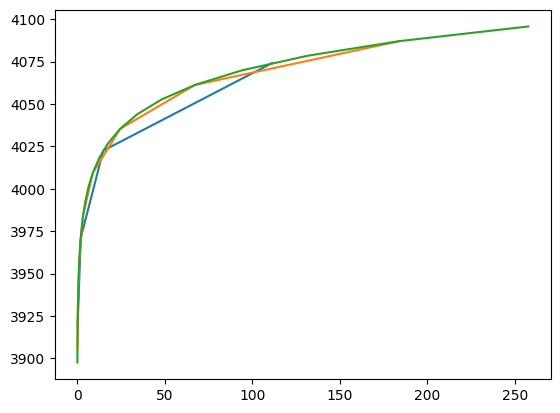

In [5]:
plt.plot(p1.rw_*np.exp(p1.y_), Pr1)
plt.plot(p2.rw_*np.exp(p2.y_), Pr2)
plt.plot(p3.rw_*np.exp(p3.y_), Pr3)

## Exercise 3: Accuracy and performance of timedependent solution

**Part 1**
- For several values of N, compare your numerical solver implementation to the line-source solution given by equation (27). To do the comparison, you need to plot your solution in terms of the *physical coordinates*, i.e.,
$r(y) = r_we^y$.

**Part 2** Next, we want to take advantage of the symmetry of the problem. At run-time, the simulator should be able to choose between three different matrix
solvers:
1. Dense, using numpy.linalg.solve.  
2. Sparse using, scipy.sparse.linalg.spsolve.  
3. Sparse, using the Thomas algorithm). An implementation of the Thomas algorithm can be found in appendix D.  
4. Use the %timeit option in Jupyter to compare the speed of each solver.  
How large must N be in order to see a difference?  

## Exercise 4: Match model to well test data

**Part 1** So far, we have calculated the pressure distribution *inside the reservoir*. The actual observable well pressure is missing from our calculations, but we can estimate it by discretizing equation (13).
- Use a first-order finite difference approximation to find a formula for the well pressure in terms of the well block pressure, $p_0$.
- In your final delivery, make sure that your numerical simulator includes a function to calculate the well pressure as a function of the well-block pressure.
Hint: Use Taylor’s formula with step-size $\Delta y/2$.

From taylor polinomial for $p_N$ at well block: $$p_0 = p(y_w + \Delta y/2) = p_w + \frac{dp}{dy_{(y=y_w)}}\Delta y/2 + \cal O(\Delta y^2)$$
Taking the 1st order and applying equation (14) $$p_0 = p_w + \frac{Q \mu}{2\pi hk}\Delta y/2$$ 
Incorporating equation (34) $$\begin{equation} p_0 = p_w + \beta /2  \end{equation} \tag{100}$$
By rearranging for $p_w$ $$\begin{equation} p_w = p_0 - \beta /2 \end{equation} \tag{101}$$

In order to calculate the well pressure in the simulator, $p_0$ in 1st row of the matries in (34) for $i = 0$ could be subsituted with equation (100) $$ i = 0\Rightarrow (1 + \xi_0)p_0^{n+1} - \xi_0 p_1^{n+1} = p_0^n - \beta \xi_0 $$
$$ \Rightarrow (1 + \xi_0)(p_w^{n+1} + \beta /2)- \xi_0 p_1^{n+1} = (p_w^n + \beta /2) - \beta \xi_0 $$
$$\begin{equation} \Rightarrow (1 + \xi_0)p_w^{n+1} - \xi_0 p_1^{n+1} = p_w^n - \frac{3}{2}\beta \xi_0 \end{equation} \tag{102} $$
Consequantly the matrix equation (34) becomes 
$$\underbrace{
\begin{pmatrix}
1 + \xi_0 & -\xi_0 & 0 & 0 \\
-\xi_1 & 1 + 2\xi_1 & -\xi_1 & 0 \\
0 & -\xi_2 & 1 + 2\xi_2 & -\xi_2 \\
0 & 0 & -\xi_3 & 1 + 3\xi_3 
\end{pmatrix}}_{A} \underbrace{\begin{pmatrix}
p_w^{n+1} \\
p_1^{n+1} \\
p_2^{n+1} \\
p_3^{n+1} 
\end{pmatrix}}_{p^{n+1}} = \underbrace{\begin{pmatrix}
p_w^{n} \\
p_1^{n} \\
p_2^{n} \\
p_3^{n} \\
\end{pmatrix}}_{p^n} + \underbrace{\begin{pmatrix}
-\frac{3}{2}\beta \xi_0 \\
0 \\
0 \\
2p_i \xi_3
\end{pmatrix}}_{d} \tag{103}$$

**Part 2**  Well test data are available in the text file well_bhp.dat (located in the data folder).
- Read the well test data into Python, and make a scatter plot of well pressures versus time.

Utilizing **Pandas** to read from the file to a data frame. Makes life much easier.  
**Plotly** module in python is used to visualize the data interactively.  
The modules could be installed with pip or conda. here is the link which shows how to use it whithin Jupyter lab/notebook:  
[Plotly installation](https://plotly.com/python/getting-started/#installation)


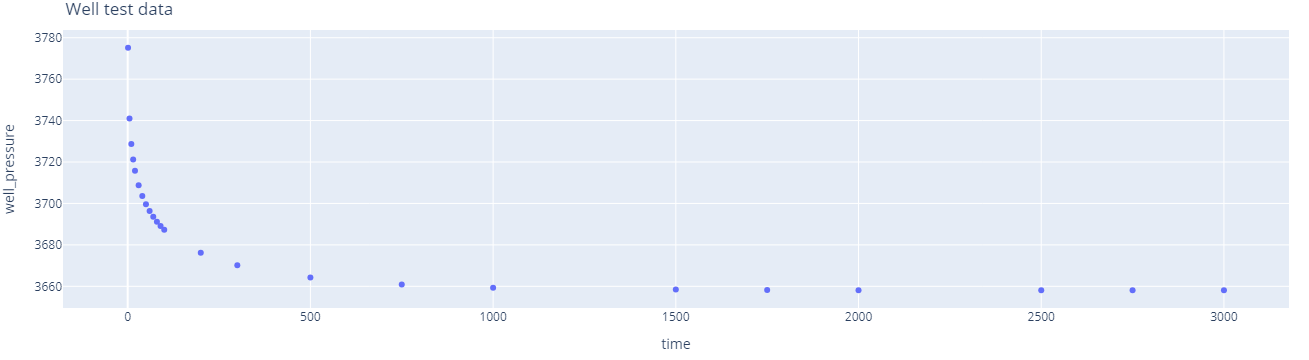

In [474]:
data = pd.read_csv('data/well_bhp.dat', sep='\t', header=0, index_col=False)
fig = px.scatter(data, x="time", y="well_pressure", title='Well test data')
fig.update_layout(margin=dict(l=10, r=20, t=30, b=20))
fig.show()

<Axes: xlabel='time', ylabel='well_pressure'>

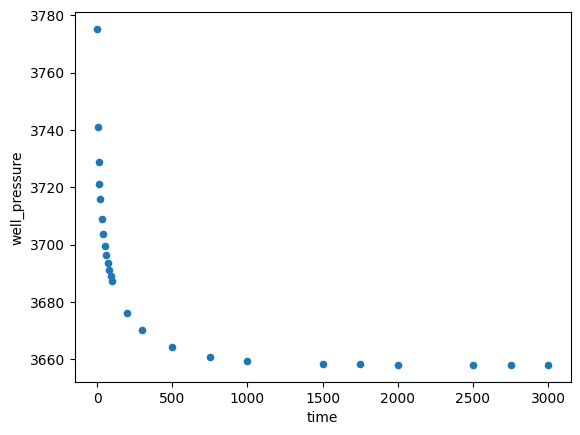

In [409]:
data.plot('time', 'well_pressure', kind='scatter')

**Part 3** Towards the end of the test, we see that the well pressure stabilizes towards a constant value. This indicates that the pressure wave has reached the edge of the reservoir. For this part you may assume default model input (Appendix B) for all parameters except the following three: $k, p_i,$ and $r_e$

- Fit your numerical model to the well test data by changing the values of $k, p_i,$ and $r_e$
- Make a plot in which you compare 1) the well test data, 2) your numerical well pressure solution, and 3) the corresponding line-source solution.
- Use a logarithmic scale on the x-axis.

Hints: You may try to match the well test curve manually, but it might be easier to use automated curve-fitting.

In [555]:
class PressureSolver_Pw(PressureSolver):
    """
    The same solver as the one for the question 2. The only difference is the introduction of Pw in the matrices.
    """
    def constants(self):
        self.c = np.zeros((self.N_, 1))
        self.c[0] = - 3/2 * self.beta_ * self.xi_[0]
        self.c[self.N_ - 1] = 2 * self.pi_ * self.xi_[self.N_ - 1]
        return self.c
    def time_advance(self):
        A = self.coefficient_matrix()
        const = self.constants()
        Pold = self.initial_condition()
        t = self.dt_
        accuracy = 1
        Pw_t = np.empty((0, 2))
        condition = False
        while not condition:
            rhs = self.rhs_matrix(Pold = Pold, const = const)
            p = self.solver(A = A, rhs = rhs)
            Pw_t = np.vstack((Pw_t, np.array([t/3600, p[0, 0]/self.psi_to_pa_])))
            # yield (p[0], t)
            if t/3600 > 3000:
                condition = True
            else:
                Pold = p
                t = t + self.dt_
        return Pw_t

In [556]:
Pw = PressureSolver_Pw(4, 0.01)
Pw_t = Pw.time_advance()

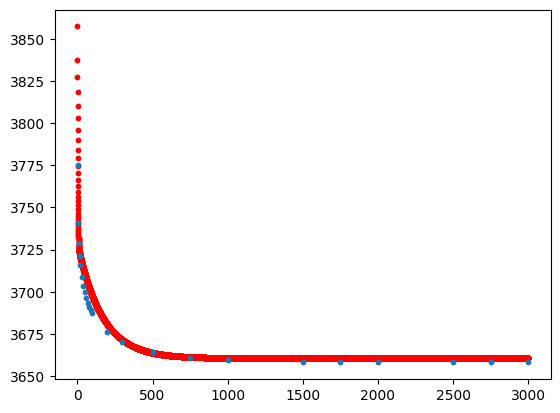

In [557]:
plt.scatter(Pw_t[:,0], Pw_t[:,1], color='red', s=10)
plt.scatter(data['time'], data['well_pressure'], s=10)
plt.show()

In [562]:
# import scipy.special as sc
from scipy.optimize import curve_fit

# define the function to fit the bserved well test data.
def func_fa(t, m, b):
    return  m * np.log10(t) + b
    

In [567]:
rw=0.318
h=11.0
phi=0.25
mu=1.0
ct=7.8e-6
Q=1000.0

In [563]:
xdata_fa = data.loc[1:12, 'time']
ydata_fa = data.loc[1:12,'well_pressure']
params_fa, pcov_fa = curve_fit(func_fa, xdata_fa, ydata_fa)

In [569]:
# par = PressureSolver(1,1)
k = 162.6*Q*mu/(-params_fa[0]*h)

In [577]:
p1h = params_fa[1]
pi = p1h - params_fa[0]*(np.log10(k/(phi*mu*ct*rw**2)) - 3.23)
pi

4018.8074422763916

Note the change in the slope of the data in semi-log plot of both curves above. The 1st slope is transient part which is used to find the permeability and initial pressure and the second one is when the pressure effect reaches the boundry. Later part will guid us to find the external reduce of the reservoir.
Refering to equation 2.4 in refference 8, $$k=162.6Q\mu/mh$$ (field unit) with $m=41.03 psi/bll/cycle \Rightarrow k=357.9 mD$  
The intercept calculated by curve fit is $P_{1h} = 3769.8 psi$  
From refference [Amant U. Chaudhry Equation 4-9] initial pressure could be calculated. No skin factor is reported so $s=0$.  
$$p_i=4019$$

using the second section of the curve (psudo stady state) where the line emerges in cartesian system. 
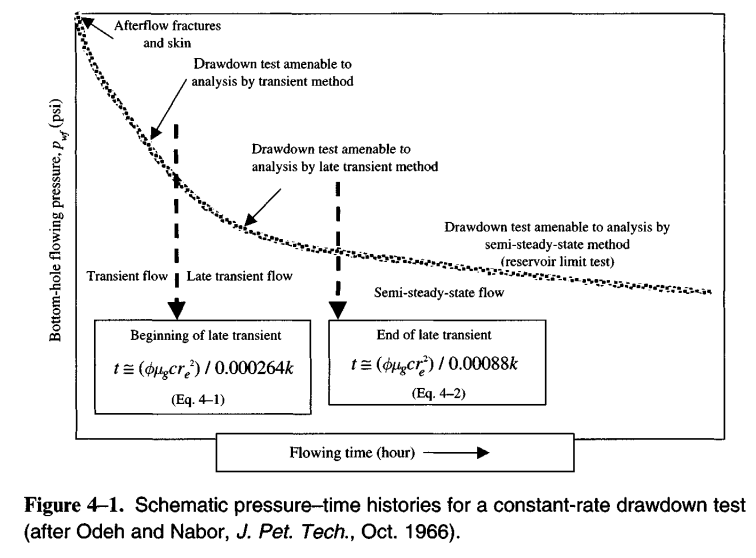

In [501]:
# define the function to fit the bserved well test data.
def func_pss(t, m, b):
    return  m * t + b

In [589]:
xdata_pss = data.loc[14:, 'time']
ydata_pss = data.loc[14:,'well_pressure']
params_pss, pcov_pss = curve_fit(func_pss, xdata_pss, ydata_pss)

In [590]:
params_pss

array([-3.13370851e-03,  3.66539757e+03])

In [591]:
re = -0.0168*k/(phi*mu*1*params_pss[0])
re*.3

2302.419801872864

**Part 4**
- Based on the value you found for $r_e$, what is the total volume of water in the reservoir?

------------------------------------
### **Reflections**:
- Jing:


- Partha:



- Hodjdat: 

### **Conclusion**: 




### **References**: 

[1]  Laurence Patrick Dake. Fundamentals of Reservoir Engineering. Elsevier, 1983.
[2]  
[3]
[4] 
[5] Aksel Hiorth. *Computational Engineering and Modeling*. https://github.com/ahiorth/CompEngineering, 2023  
[6] Robert Edwin Wengert. A simple automatic derivative evaluation program. Communications of the ACM, 7(8):463–464, 1964.